In [1]:
# Automatic reload 
# %load_ext autoreload
# %autoreload 2
from tcrpeg_toolkit.plot_heatmap_pinfer import PlotHeatmapPinfer

In [21]:
plot_heatmap = PlotHeatmapPinfer(data='results_sample_data/p_infer/raw/')

INFO - Loaded 2 files


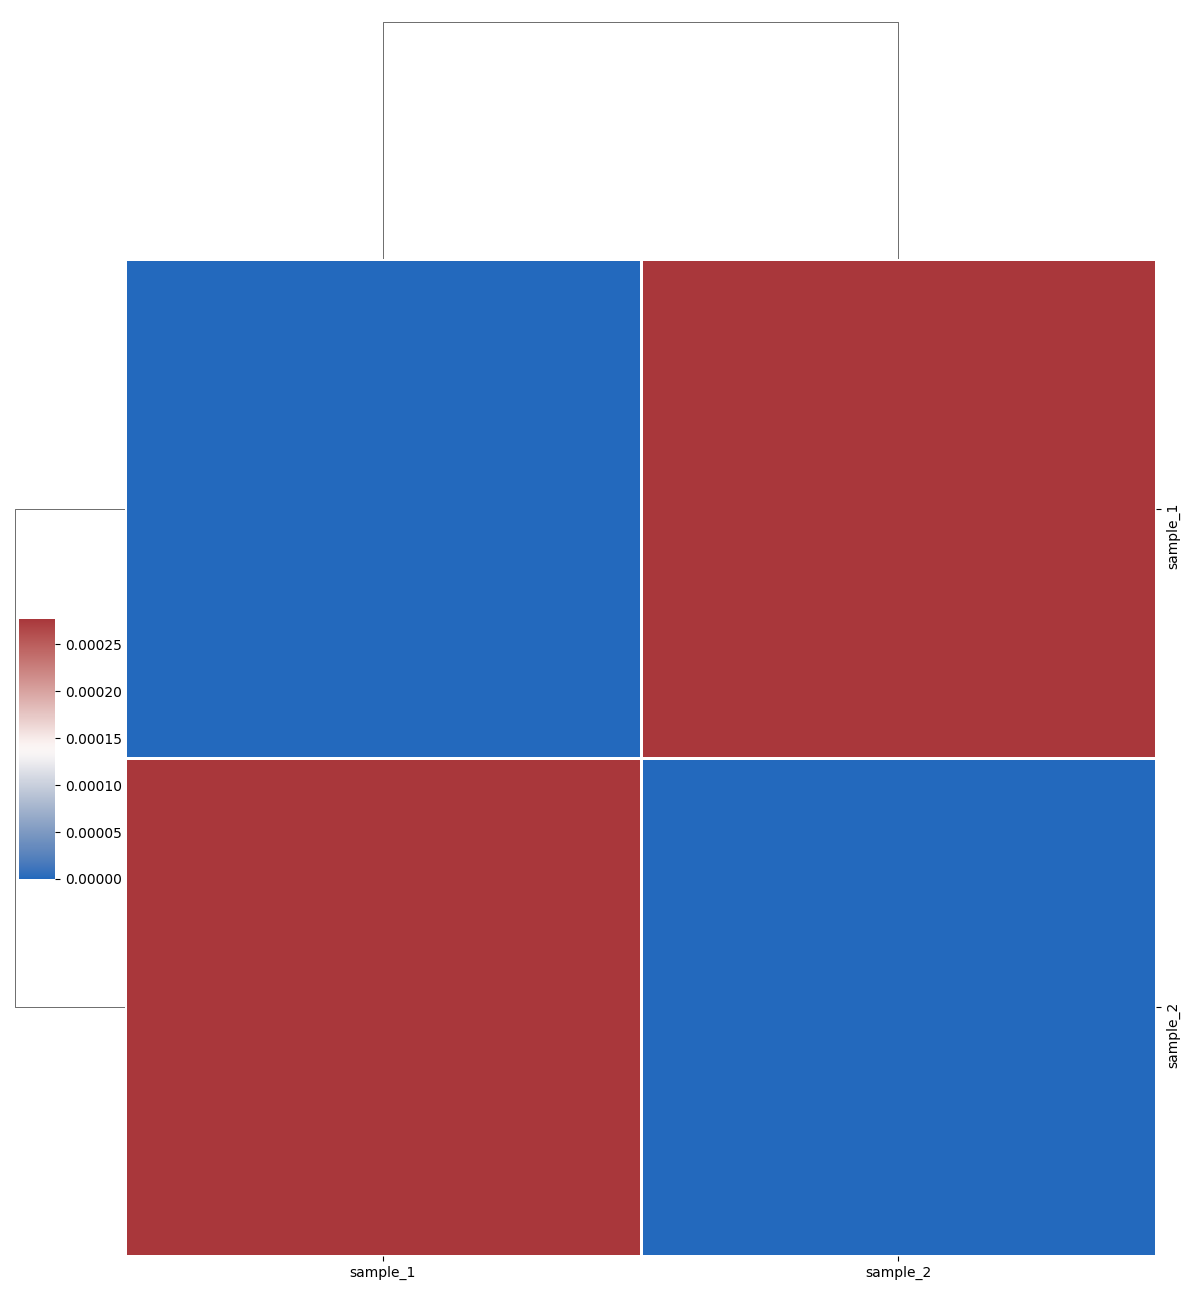

In [3]:
plot_heatmap.run()

In [28]:
plot_heatmap_metadata = PlotHeatmapPinfer(data='results_sample_data/p_infer/raw/', metadata='sample_data/metadata.csv')

INFO - Loading data...


INFO - Data loaded from sample_data/metadata.csv


In [5]:
p_infer_dict = plot_heatmap_metadata.load_data_numpy(plot_heatmap_metadata.data)

INFO - Loaded 2 files


In [6]:
distance_matrix = plot_heatmap_metadata.calculate_distance(p_infer_dict)

In [7]:
metadata_multi_idx = plot_heatmap_metadata.create_multi_index(plot_heatmap_metadata.metadata)

In [8]:
metadata_multi_idx

MultiIndex([(1, ' CD4', ' Healthy', ' PLN'),
            (2, ' CD8', ' Healthy', ' RLN')],
           names=['sample', 'cell_subset', 'disease', 'tissue'])

In [9]:
distance_matrix_annotated = plot_heatmap_metadata.annotate_distance_matrix(distance_matrix, metadata_multi_idx)

In [10]:
distance_matrix_annotated

,,,sample,1,2
,,,cell_subset,CD4,CD8
,,,disease,Healthy,Healthy
,,,tissue,PLN,RLN
sample,cell_subset,disease,tissue,,
1,CD4,Healthy,PLN,0.000000,0.000277
2,CD8,Healthy,RLN,0.000277,0.000000


In [11]:
metadata_multi_idx_colors = plot_heatmap_metadata.assign_metadata_color(metadata_multi_idx) if metadata_multi_idx is not None else None

In [12]:
metadata_multi_idx_colors

,,,,sample,cell_subset,disease,tissue
sample,cell_subset,disease,tissue,,,,
1,CD4,Healthy,PLN,NaN,"(0.4, 0.7607843137254902, 0.6470588235294118)","(0.12156862745098039, 0.4666666666666667, 0.70...","(0.6509803921568628, 0.807843137254902, 0.8901..."
2,CD8,Healthy,RLN,NaN,"(0.9882352941176471, 0.5529411764705883, 0.384...","(0.12156862745098039, 0.4666666666666667, 0.70...","(0.12156862745098039, 0.47058823529411764, 0.7..."


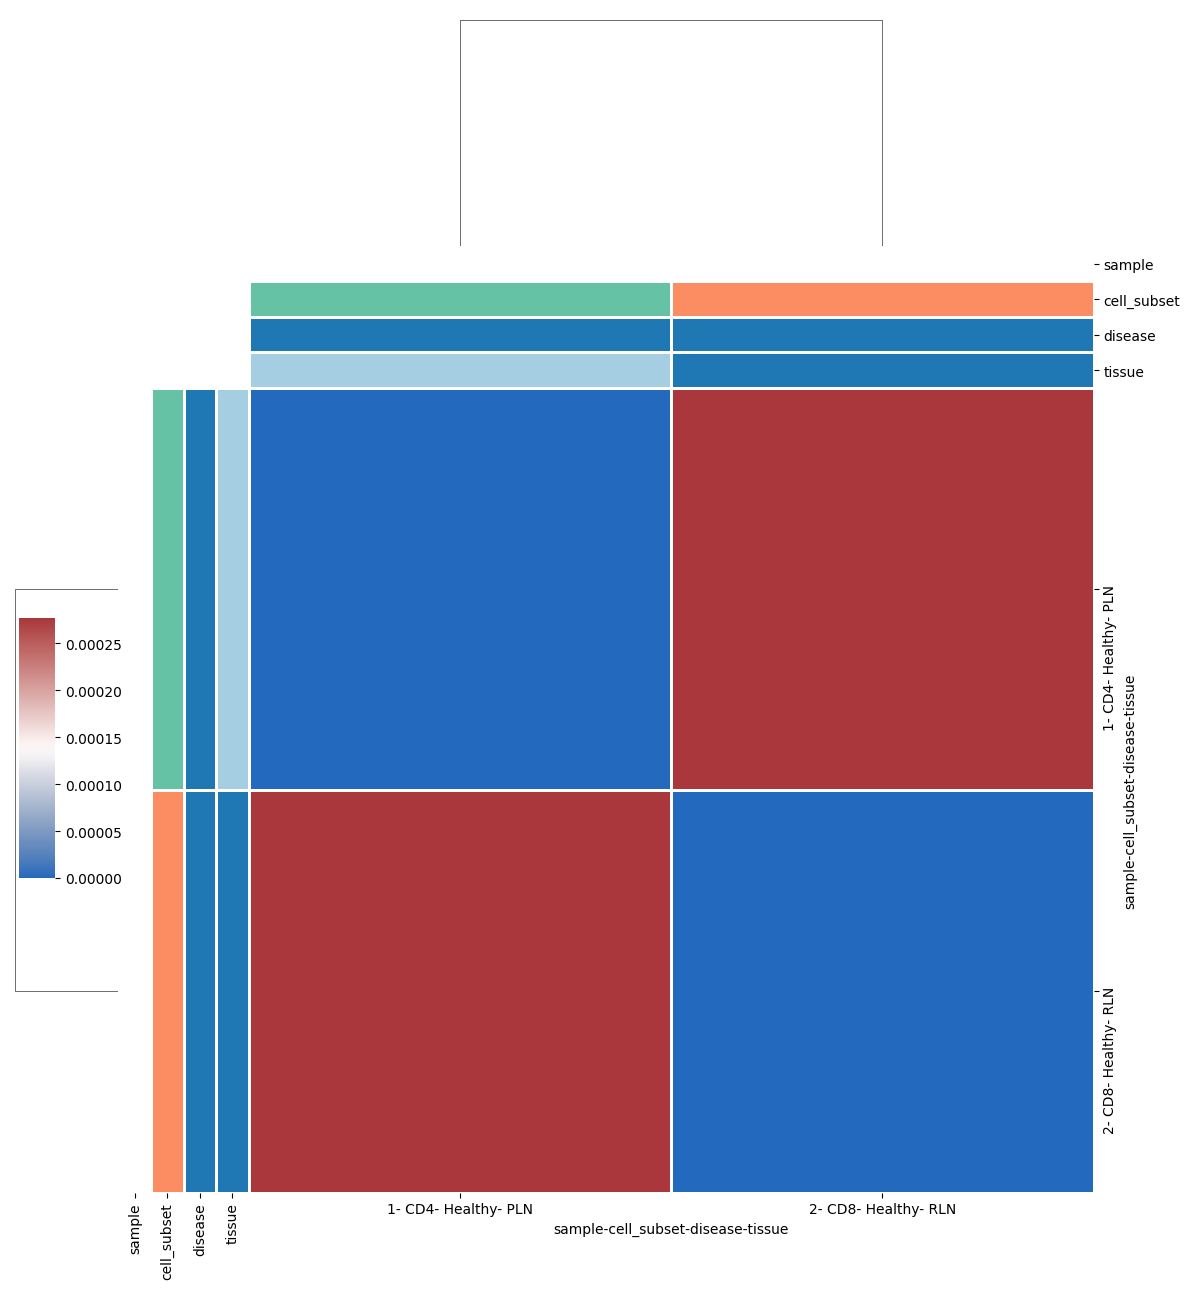

In [13]:
plot_heatmap_metadata.plot_heatmap(distance_matrix_annotated, row_colors=metadata_multi_idx_colors, col_colors=metadata_multi_idx_colors)

In [29]:
plot_heatmap_metadata._create_color_palette(plot_heatmap_metadata.metadata, 'sample')

(0    NaN
 1    NaN
 Name: sample, dtype: object,
 {'1': (0.8167028311697733, 0.5345122109266688, 0.5750280113923723),
  '2': (0.46712078684915886, 0.6454760674453914, 0.6277122757100324)})

In [30]:
plot_heatmap_metadata._create_color_palette(plot_heatmap_metadata.metadata, 'tissue')

(0    (0.8167028311697733, 0.5345122109266688, 0.575...
 1    (0.46712078684915886, 0.6454760674453914, 0.62...
 Name: tissue, dtype: object,
 {'PLN': (0.8167028311697733, 0.5345122109266688, 0.5750280113923723),
  'RLN': (0.46712078684915886, 0.6454760674453914, 0.6277122757100324)})

In [27]:
plot_heatmap_metadata.metadata.columns

Index(['id', ' sample', ' cell_subset', ' disease', ' tissue'], dtype='object')